Добрый день. При автоматизации работы с документацией иногда приходится иметь дело со сканами плохого качества. Особенно удручает ситуация, при которой вместо сканированного документа предоставляется фото с телефона.

В области обработки документов существует целый ряд задач, которые решаются с помощью машинного обучения. С примерным списком можно ознакомиться в [данной статье](https://habr.com/ru/company/smartengines/blog/492696/). В этом руководстве я предлагаю решение проблемы различных помех на фото документа, которые могут возникнуть при плохом качестве съемки или плохом качестве самого документа.

Для борьбы с помехами на фото будем использовать автоэнкодер на основе сверточной сети.

Работать будем в облачном сервисе Google Colab.

Для начала скачаем набор данных с фотографиями документов с помощью API сайта kaggle.com, который является популярной платформой для соревнований по Data Science. Для того, чтобы воспользоваться API сайта, нужно получить файл *kaggle.json* из личного кабинета, следуя [инструкции](https://www.kaggle.com/general/156610).

In [ ]:
!pip install -q kaggle
from google.colab import files

files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d uurdeep/cleaning-dirty-documents-unzipped

In [ ]:
!pip install -q kaggle
from google.colab import drive
drive.mount('/content/drive')

!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d uurdeep/cleaning-dirty-documents-unzipped

Разархивируем скачанный архив данными. У нас появится две папки. В одной находятся зашумленные изображения (*train*), в другой чистые изображения (*train_cleaned*).

In [2]:
!unzip -q cleaning-dirty-documents-unzipped.zip

Импортируем нужные библиотеки. Для создания и обучения модели будем использовать библиотеку PyTorch.

In [3]:
import os
import cv2
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


from google.colab.patches import cv2_imshow
from tqdm import tqdm
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split

Рассмотрим, что представляют из себя данные:

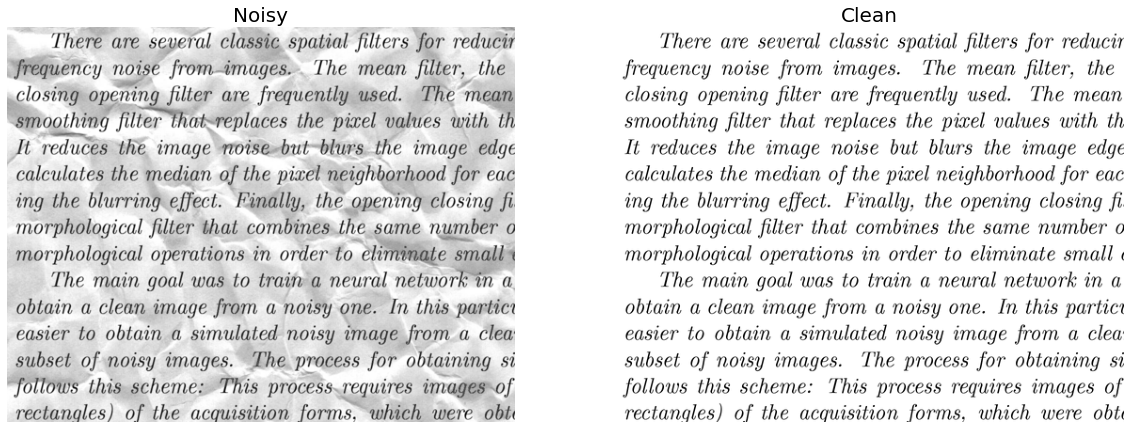

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = os.listdir('/content/train')[0]
fig, ax = plt.subplots(1,2, figsize=(20, 10))
img_noisy = mpimg.imread(f'/content/train/{img}')
img_clean = mpimg.imread(f'/content/train_cleaned/{img}')

ax[0].imshow(img_noisy, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Noisy', fontsize = 20)

ax[1].imshow(img_clean, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Clean', fontsize = 20);

Сформируем выборку для тренировки модели и для проверки её качества:

In [5]:
train_imgs, test_imgs = train_test_split(os.listdir('/content/train'), test_size=0.33, random_state=123)

Выберем устройство, на котором будет обучаться модель:

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

Для удобства работы с данными создадим вспомогательный класс на основе `torch.utils.data.Dataset`. Переопределим методы `__len__` и `__getitem__` под наши данные.

Данный класс будет принимать на вход путь к папке с зашумленными изображениями, сам список с изображениями и, еще по необходимости, путь до чистых файлов и объект класса `torchvision.transforms.transforms`, содержащий список трансформаций над изображениями. При обращении по индексу данный класс будет возвращать кортеж из зашумленного изображения в формате `torch.Tensor` и его название в каталоге. Если указана директория для чистых изображений, то будет возвращено еще изображение без шума.

In [7]:
class NoisyCleanDataset(Dataset):
    def __init__(self, noisy_path, images, clean_path=None, transforms=None):
        self.noisy_path = noisy_path
        self.clean_path = clean_path
        self.images = images
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.images))
    
    def __getitem__(self, i):
        noisy_image = cv2.imread(f"{self.noisy_path}/{self.images[i]}")
        noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2GRAY)
        
        if self.transforms:
            noisy_image = self.transforms(noisy_image)
            
        if self.clean_path is not None:
            clean_image = cv2.imread(f"{self.clean_path}/{self.images[i]}")
            clean_image = cv2.cvtColor(clean_image, cv2.COLOR_BGR2GRAY)
            clean_image = self.transforms(clean_image)
            return (noisy_image, clean_image, self.images[i])
        else:
            return (noisy_image, self.images[i])

Определим трансформации для изображения в переменной `transform`. При трансформации изображение будет изменено под размер 400 на 400 пикселей и возвращено в формате `torch.Tensor`.

In [8]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
])

Создадим нашу модель. Она будет состоять из двух блоков. Первый блок (энкодер) уменьшает размерность изображения, извлекая из него нужные признаки. Второй блок (декодер) пытается восстановить изображения по извлеченным признакам.

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()    

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = nn.functional.interpolate(encoded, scale_factor=2)
        decoded = self.decoder(decoded)
        return decoded

Создадим класс, в котором реализуем обучение и предсказание модели. А также добавим возможность выводить информацию о модели, сохранять и загружать веса модели.

In [10]:
class MyModel():
    def __init__(self, Dataset, Model, transforms):
        self.Dataset = Dataset
        self.model = Model().to(device)
        self.transform = transforms

    def load_weights(self, path):
        if device == 'cpu':
            self.model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
        else:
            self.model.load_state_dict(torch.load(path))

    def save_weights(self, path):
        torch.save(self.model.state_dict(), path)

    def show_info(self):
        print(summary(self.model, (1, 400, 400)))

    def fit(self, n_epochs, noisy_path, clean_path, train_imgs, test_imgs):
        
        train_data = self.Dataset(noisy_path, train_imgs, clean_path, self.transform)
        val_data = self.Dataset(noisy_path, test_imgs, clean_path, self.transform)
        
        trainloader = DataLoader(train_data, batch_size=4, shuffle=True)
        valloader = DataLoader(val_data, batch_size=4, shuffle=False)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                optimizer,
                mode='min',
                patience=5,
                factor=0.5,
                verbose=True
            )

        self.model.train()
        self.train_loss = []
        self.val_loss = []
        running_loss = 0.0

        for epoch in range(n_epochs):
            self.model.train()
            for i, data in enumerate(trainloader):
                noisy_img = data[0]
                clean_img = data[1]
                noisy_img = noisy_img.to(device)
                clean_img = clean_img.to(device)
                optimizer.zero_grad()
                outputs = self.model(noisy_img)
                loss = criterion(outputs, clean_img)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                if i % 10 == 0:
                    print(f'Epoch {epoch+1} batch {i}: Loss {loss.item()/4}')
            self.train_loss.append(running_loss/len(trainloader.dataset))
            print('Validation ...')
            self.model.eval()
            running_loss = 0.0
            with torch.no_grad():
                for i, data in tqdm(enumerate(valloader), total=int(len(val_data)/valloader.batch_size)):
                    noisy_img = data[0]
                    clean_img = data[1]
                    noisy_img = noisy_img.to(device)
                    clean_img = clean_img.to(device)
                    outputs = self.model(noisy_img)
                    loss = criterion(outputs, clean_img)
                    running_loss += loss.item()
                current_val_loss = running_loss/len(valloader.dataset)
                self.val_loss.append(current_val_loss)
                print(f"Val Loss: {current_val_loss:.5f}")

    def predict(self, img):
        os.makedirs('outputs', exist_ok=True)
        self.model.eval()
        if type(img) == str:
            if os.path.isfile(img):
                filename = os.path.basename(img)
                img = cv2.imread(img)
                img  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = self.transform(img).to(device)
                img = self.model(img)
                img = img.detach().cpu().permute(1,2,0).numpy()
                cv2.imwrite(f'outputs/{filename}', img*255)
            else:
                images = os.listdir(img)
                predictDataset = self.Dataset(img, images, transforms=self.transform)
                predictDataloader = DataLoader(predictDataset, batch_size=4, shuffle=False)
                with torch.no_grad():
                    for i, data in tqdm(enumerate(predictDataloader), total=int(len(predictDataset)/predictDataloader.batch_size)):
                        noisy_img = data[0]
                        noisy_img = noisy_img.to(device)
                        outputs = self.model(noisy_img)
                        for im, image_name in zip(outputs, data[1]):
                            im = im.detach().cpu().permute(1,2,0).numpy()
                            cv2.imwrite(f'outputs/{image_name}', im*255)
        if type(img) == np.ndarray:
            if img.shape[2] == 3:
                img  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = self.transform(img).to(device)
            img = self.model(img)
            img = img.detach().cpu().permute(1,2,0).numpy()
            cv2.imwrite('outputs/cleaned_img.jpg', img*255)

При создании класса нужно будет указать ссылку на наш вспомогательный класс для работы с данными, ссылку на модель и на переменную, содержащую список трансформаций.

Основным методом является `fit`, который отвечает за обучение модели. На вход он принимает число эпох для обучения, ссылки на папки с зашумленными и чистыми изображениями, а также список изображений для тренировки или валидации. Далее на основе нашего вспомогательного класса для работы с данными создаются две переменные, которые подаются в еще один вспомогательный класс `torch.utils.data.DataLoader`, который отвечает за распределенную обработку данных.

В качестве функции потерь возьмем среднюю квадратичную ошибку. А в качестве оптимизатора алгоритм *Adam*. Также зададим регулятор градиентного шага из `torch.optim.lr_scheduler`. Данный регулятор будет уменьшать градиентный шаг, если показатель функции потерь перестает уменьшаться.

После каждой 10 итерации будет выводиться сообщение с информацией о эпохе, номере батча, значении функции потерь. После каждой эпохи будет проводиться валидация. Значения функции будут записываться в переменные, чтобы потом можно было посмотреть на графике процесс обучения.

Метод `predict` позволяет использовать готовую модель для тестирования на изображениях. Данный метод может принимать либо ссылку на каталог с изображениями, либо ссылку на отдельное изображение, либо изображение в формате массива. Изображения, обработанные моделью, будут сохраняться в папку *outputs*.

Инициализируем наш класс:

In [11]:
AutoEncoder = MyModel(NoisyCleanDataset, Autoencoder, transform)

Посмотрим структуру модели:

In [12]:
AutoEncoder.show_info()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 400, 400]           3,328
              ReLU-2        [-1, 128, 400, 400]               0
         MaxPool2d-3        [-1, 128, 200, 200]               0
            Conv2d-4        [-1, 128, 200, 200]         147,584
              ReLU-5        [-1, 128, 200, 200]               0
            Conv2d-6          [-1, 1, 400, 400]           1,153
           Sigmoid-7          [-1, 1, 400, 400]               0
Total params: 152,065
Trainable params: 152,065
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.61
Forward/backward pass size (MB): 432.13
Params size (MB): 0.58
Estimated Total Size (MB): 433.32
----------------------------------------------------------------
None


Запустим обучение модели на 40 эпохах:

In [ ]:
AutoEncoder.fit(40, 
        '/content/train', 
        '/content/train_cleaned',
        train_imgs, 
        test_imgs)

Сохраним веса обученной модели:

In [65]:
AutoEncoder.save_weights('model1.pth')
#AutoEncoder.load_weights('model1.pth')

Визуализируем процесс обучения:

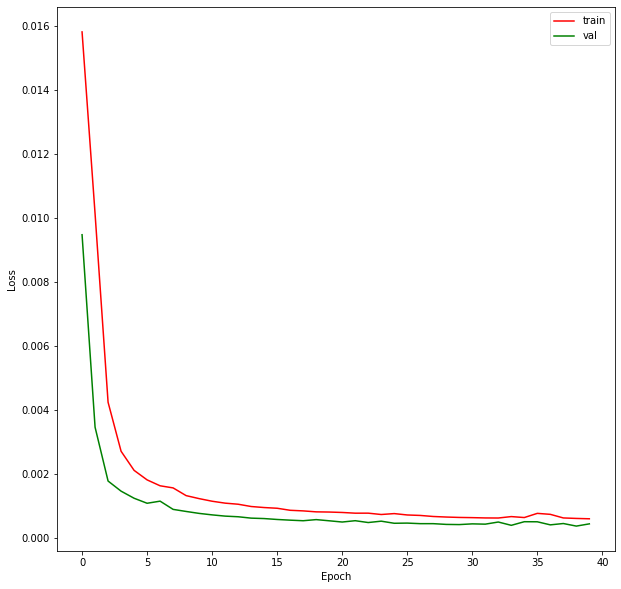

In [14]:
f, ax = plt.subplots(figsize=(10, 10))
ax.plot(AutoEncoder.train_loss, color='red', label='train')
ax.plot(AutoEncoder.val_loss, color='green', label='val')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend();

Применим модель к изображениям в тестовой папке:

In [15]:
AutoEncoder.predict('/content/train')

100%|██████████| 36/36 [00:02<00:00, 15.49it/s]


Напишем небольшую функцию, которая будет визуализировать оригинальное, зашумленное и восстановленное моделью изображение:

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_pair_img(img):
    fig, ax = plt.subplots(1,3, figsize=(21, 7))
    img_noisy = cv2.resize(mpimg.imread(f'/content/train/{img}'), (400, 400))
    img_clean = cv2.resize(mpimg.imread(f'/content/train_cleaned/{img}'), (400, 400))
    img_cleaned = mpimg.imread(f'/content/outputs/{img}')

    ax[0].imshow(img_clean, cmap='gray')
    ax[0].axis('off')
    ax[0].set_title('Clean', fontsize = 20)

    ax[1].imshow(img_noisy, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Noisy', fontsize = 20);

    ax[2].imshow(img_cleaned, cmap='gray')
    ax[2].axis('off')
    ax[2].set_title('Cleaned', fontsize = 20);

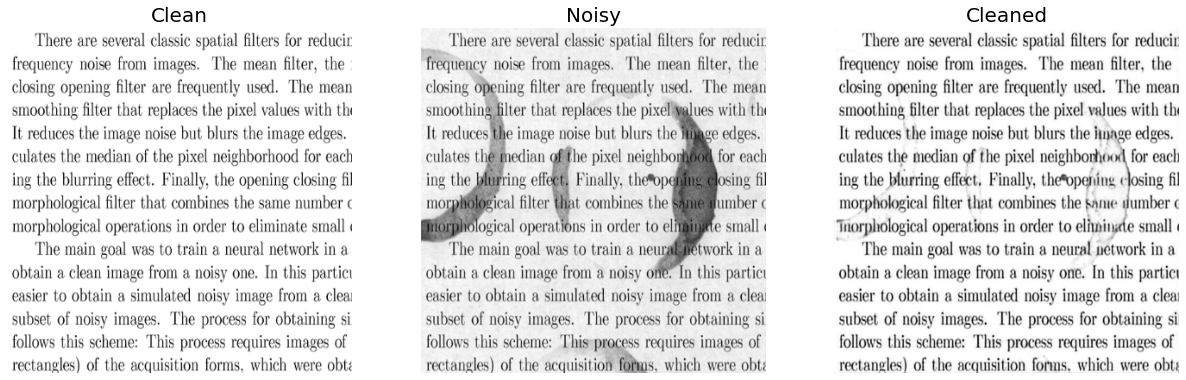

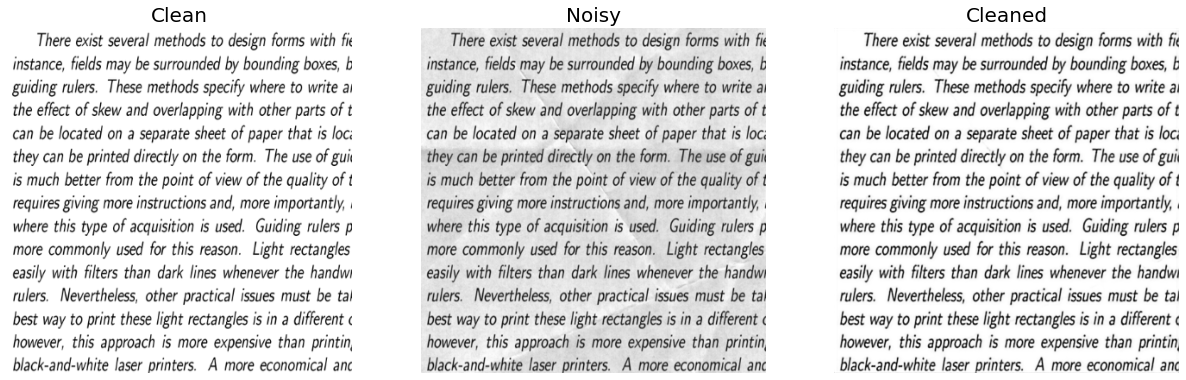

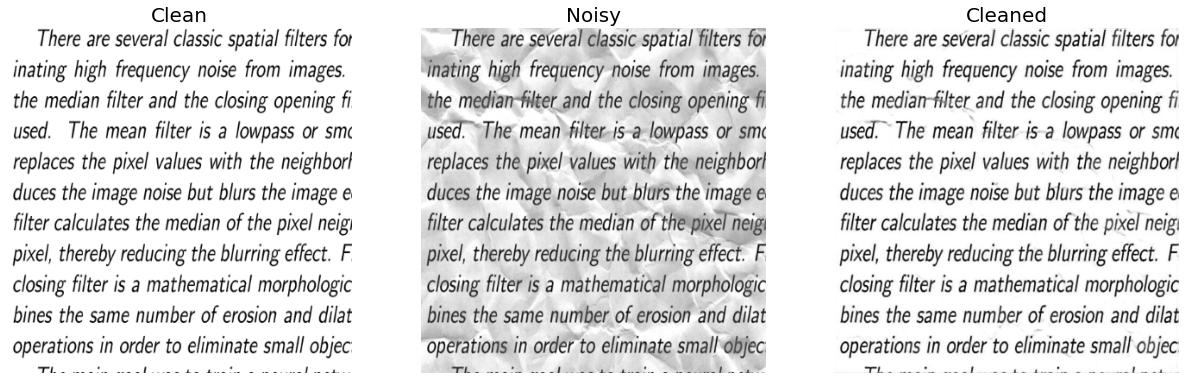

In [24]:
for i in range(3):
    show_pair_img(test_imgs[i])

Слева представлено оригинальное изображение, по центру то же изображение, но с фоновым шумом. Справа находится изображение, которое было восстановлено из зашумленного. Восстановленное изображение смотрится гораздо лучше, чем его зашумленная копия.

Таким образом нам удалось частично убрать фоновый шум с изображения с помощью сверточной нейронной сети. Существуют и другие архитектуры, способные принимать на входе и возвращать на выходе изображения. К примеру - генеративно состязательные модели ([GAN](https://arxiv.org/pdf/1902.04664.pdf)).

К ограничениям нашей модели стоит отнести тот факт, что она обучалась на искусственно зашумленных данных с определенным паттерном фона. При этом текст был на английском языке. Из-за этого можно предположить ухудшение качества модели для изображений с текстом других языков. Также в реальности символы могут иметь другую форму. Например, буквы на измятом листе будут выглядеть на фото под углом, нежели в нашем датасете, где все буквы имеют правильную форму. Убирание данных ограничений является более сложной задачей, требующей более сложной архитектуры. Помимо этого, необходимо собрать репрезентативный набор реальных данных, который должен содержать изображение в хорошем качестве и его плохую копию.